# PlantSeg SLIC-GASP

An experimental trial on integrating SLIC superpixels and GASP algorithm as the single cell segmentation over PlantSeg deep learning probability output.

In [5]:
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
from cuda_slic.slic import slic as cuda_slic
from skimage.segmentation import slic as skimage_slic
from cellpose import utils
from cellpose.plot import *
from pyHisto import io

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import multiprocessing

import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow

from skimage import exposure

from tqdm import tqdm

## Data Loading

In [2]:
# INPUT = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"
INPUT = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488-Create Image Subset-01.czi"

In [3]:
SCENE_IDX=0
CH_IDX=1
SUBSAMPLE=10
TAIL=1

In [6]:
img = io.czi_read(INPUT, channel=CH_IDX,scene=0,skip=1)
img.shape # XYC

image size (px): (4214, 3904, 1)


Merging: 100%|██████████| 6/6 [00:00<00:00, 155.73it/s]


(4214, 3904, 1)

(-0.5, 4213.5, 3903.5, -0.5)

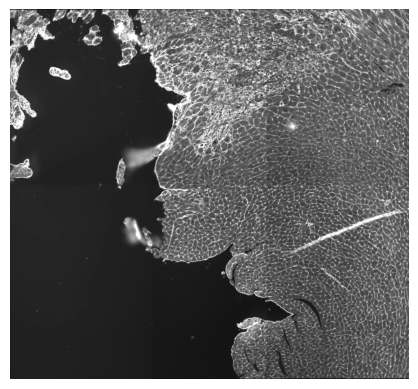

In [7]:
plt.imshow(img[:,:,0].T, cmap="gray")
plt.axis("off")

## PlantSeg Prediction
PlantSeg is a 2 step cell segmentation method, a convolution neural network (CNN) based edge probability prediction + GASP algorithm.

### CNN Edge Probability Prediction

In [8]:
# normalize exposure
pl, pu = np.percentile(img, (TAIL, 100-TAIL))
img_rescaled = exposure.rescale_intensity(img, in_range=(pl, pu),out_range=(0,1))

In [9]:
pred = unet_predictions(img_rescaled[np.newaxis,:,:,0],"lightsheet_2D_unet_root_ds1x",patch=[1,1000,1000])

2024-05-02 14:13:07,829 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 30/30 [00:05<00:00,  5.04it/s]


(-0.5, 4213.5, 3903.5, -0.5)

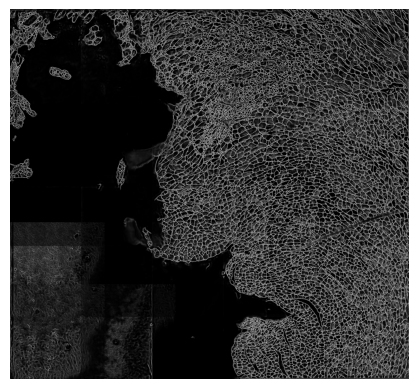

In [10]:
plt.imshow(pred[0,:,:].T, cmap="gray",vmin=0,vmax=1)
plt.axis("off")

## GASP Segmentation
GASP algorithm allows superpixels input over starting from the pixel grid-graph. Here we test the performance with:

1. No superpixels
2. Distance transform watershed (+- background mask)
3. skimage SLIC (+- background mask)
4. CUDA SLIC (background mask in development)

(-0.5, 4213.5, 3903.5, -0.5)

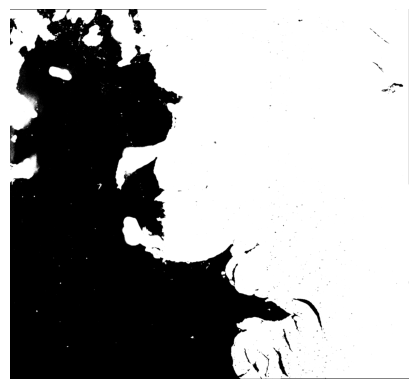

In [11]:
# background mask
mask = np.zeros_like(img[:,:,0])
mask[img[:,:,0] >= 3000] = 1

plt.imshow(mask.T,cmap="gray")
plt.axis("off")

(-0.5, 4213.5, 3903.5, -0.5)

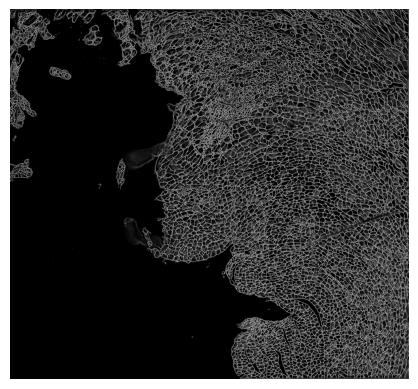

In [12]:
pred_masked = pred[0,:,:]
pred_masked[mask==0] = 0

plt.imshow(pred_masked.T,cmap="gray")
plt.axis("off")

### Watershed Supercluster

In [13]:
%%timeit -r1 -n1
dt_ws = dt_watershed(
    boundary_pmaps= pred_masked.T,
    threshold = 0.5,
    sigma_seeds = 1.,
    stacked = False,
    sigma_weights = 2.,
    min_size = 10,
    alpha = 1.0,
    pixel_pitch = None,
    apply_nonmax_suppression = False,
    n_threads = None,
    mask = None)

7.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -r1 -n1 -o
dt_watershed(
    boundary_pmaps= pred_masked.T,
    threshold = 0.5,
    sigma_seeds = 1.,
    stacked = False,
    sigma_weights = 2.,
    min_size = 10,
    alpha = 1.0,
    pixel_pitch = None,
    apply_nonmax_suppression = False,
    n_threads = None,
    mask = mask.T.astype(np.bool)
    )

<magic-timeit>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


6.65 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 6.65 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [15]:
dt_ws = dt_watershed(
    boundary_pmaps= pred_masked.T,
    threshold = 0.5,
    sigma_seeds = 1.,
    stacked = False,
    sigma_weights = 2.,
    min_size = 10,
    alpha = 1.0,
    pixel_pitch = None,
    apply_nonmax_suppression = False,
    n_threads = None,
    mask = None)

In [16]:
dt_ws_masked = dt_watershed(
    boundary_pmaps= pred_masked.T,
    threshold = 0.5,
    sigma_seeds = 1.,
    stacked = False,
    sigma_weights = 2.,
    min_size = 10,
    alpha = 1.0,
    pixel_pitch = None,
    apply_nonmax_suppression = False,
    n_threads = None,
    mask = mask.T.astype(np.bool)
    )

/tmp/ipykernel_813614/2170911252.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = mask.T.astype(np.bool)


/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/cupy/_environment.py:445: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/pyclesperanto_prototype/_tier9/_

Text(0.5, 1.0, 'DTWS Superpixels (masked)')

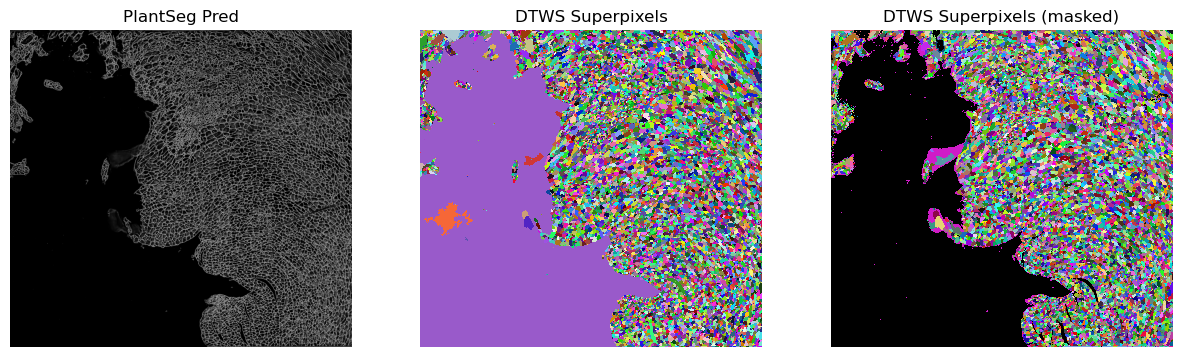

In [17]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(pred_masked.T,cmap="gray")
axs[0].set_axis_off()
axs[0].set_title("PlantSeg Pred")
cle.imshow(dt_ws, plot=axs[1],labels=True)
axs[1].set_axis_off()
axs[1].set_title("DTWS Superpixels")
cle.imshow(dt_ws_masked, plot=axs[2],labels=True)
axs[2].set_axis_off()
axs[2].set_title("DTWS Superpixels (masked)")

### SLIC

In [18]:
n_segments=500
compactness=0.1
max_iter=10

In [19]:
%%timeit -r1 -n1
skimage_slic(pred_masked, n_segments=n_segments, multichannel=False, compactness=compactness, max_num_iter=max_iter)

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `channel_axis` instead.
  warnings.warn(self.warning_msg.format(


10.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [20]:
%%timeit -r1 -n1
skimage_slic(pred_masked, n_segments=n_segments, multichannel=False, compactness=compactness, max_num_iter=max_iter, mask=mask)

18.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
%%timeit -r1 -n1
slic_cuda = cuda_slic(
    pred_masked, 
    n_segments=n_segments, 
    multichannel=False, 
    max_iter=max_iter, 
    compactness=compactness,
    spacing=(1,1,1), 
    convert2lab=None, 
    enforce_connectivity=True, 
    min_size_factor=0.5, 
    max_size_factor=3, 
    )

1.71 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
slic_ski = skimage_slic(
    pred_masked, 
    n_segments=n_segments, 
    multichannel=False, 
    max_num_iter=max_iter, 
    compactness=compactness,
    sigma=0, 
    spacing=None, 
    convert2lab=None, 
    enforce_connectivity=True, 
    min_size_factor=0.5, 
    max_size_factor=3, 
    slic_zero=False, 
    mask=None
    )

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `slic`. It will be removed in version 1.0. Please use `channel_axis` instead.
  warnings.warn(self.warning_msg.format(


In [23]:
slic_ski_masked = skimage_slic(
    pred_masked, 
    n_segments=n_segments, 
    multichannel=False, 
    max_num_iter=max_iter, 
    compactness=compactness,
    sigma=0, 
    spacing=None, 
    convert2lab=None, 
    enforce_connectivity=True, 
    min_size_factor=0.5, 
    max_size_factor=3, 
    slic_zero=False, 
    mask=mask)

In [24]:
slic_cuda = cuda_slic(
    pred_masked, 
    n_segments=n_segments, 
    multichannel=False, 
    max_iter=max_iter, 
    compactness=compactness,
    spacing=(1,1,1), 
    convert2lab=None, 
    enforce_connectivity=True, 
    min_size_factor=0.5, 
    max_size_factor=3, 
    )

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:34: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


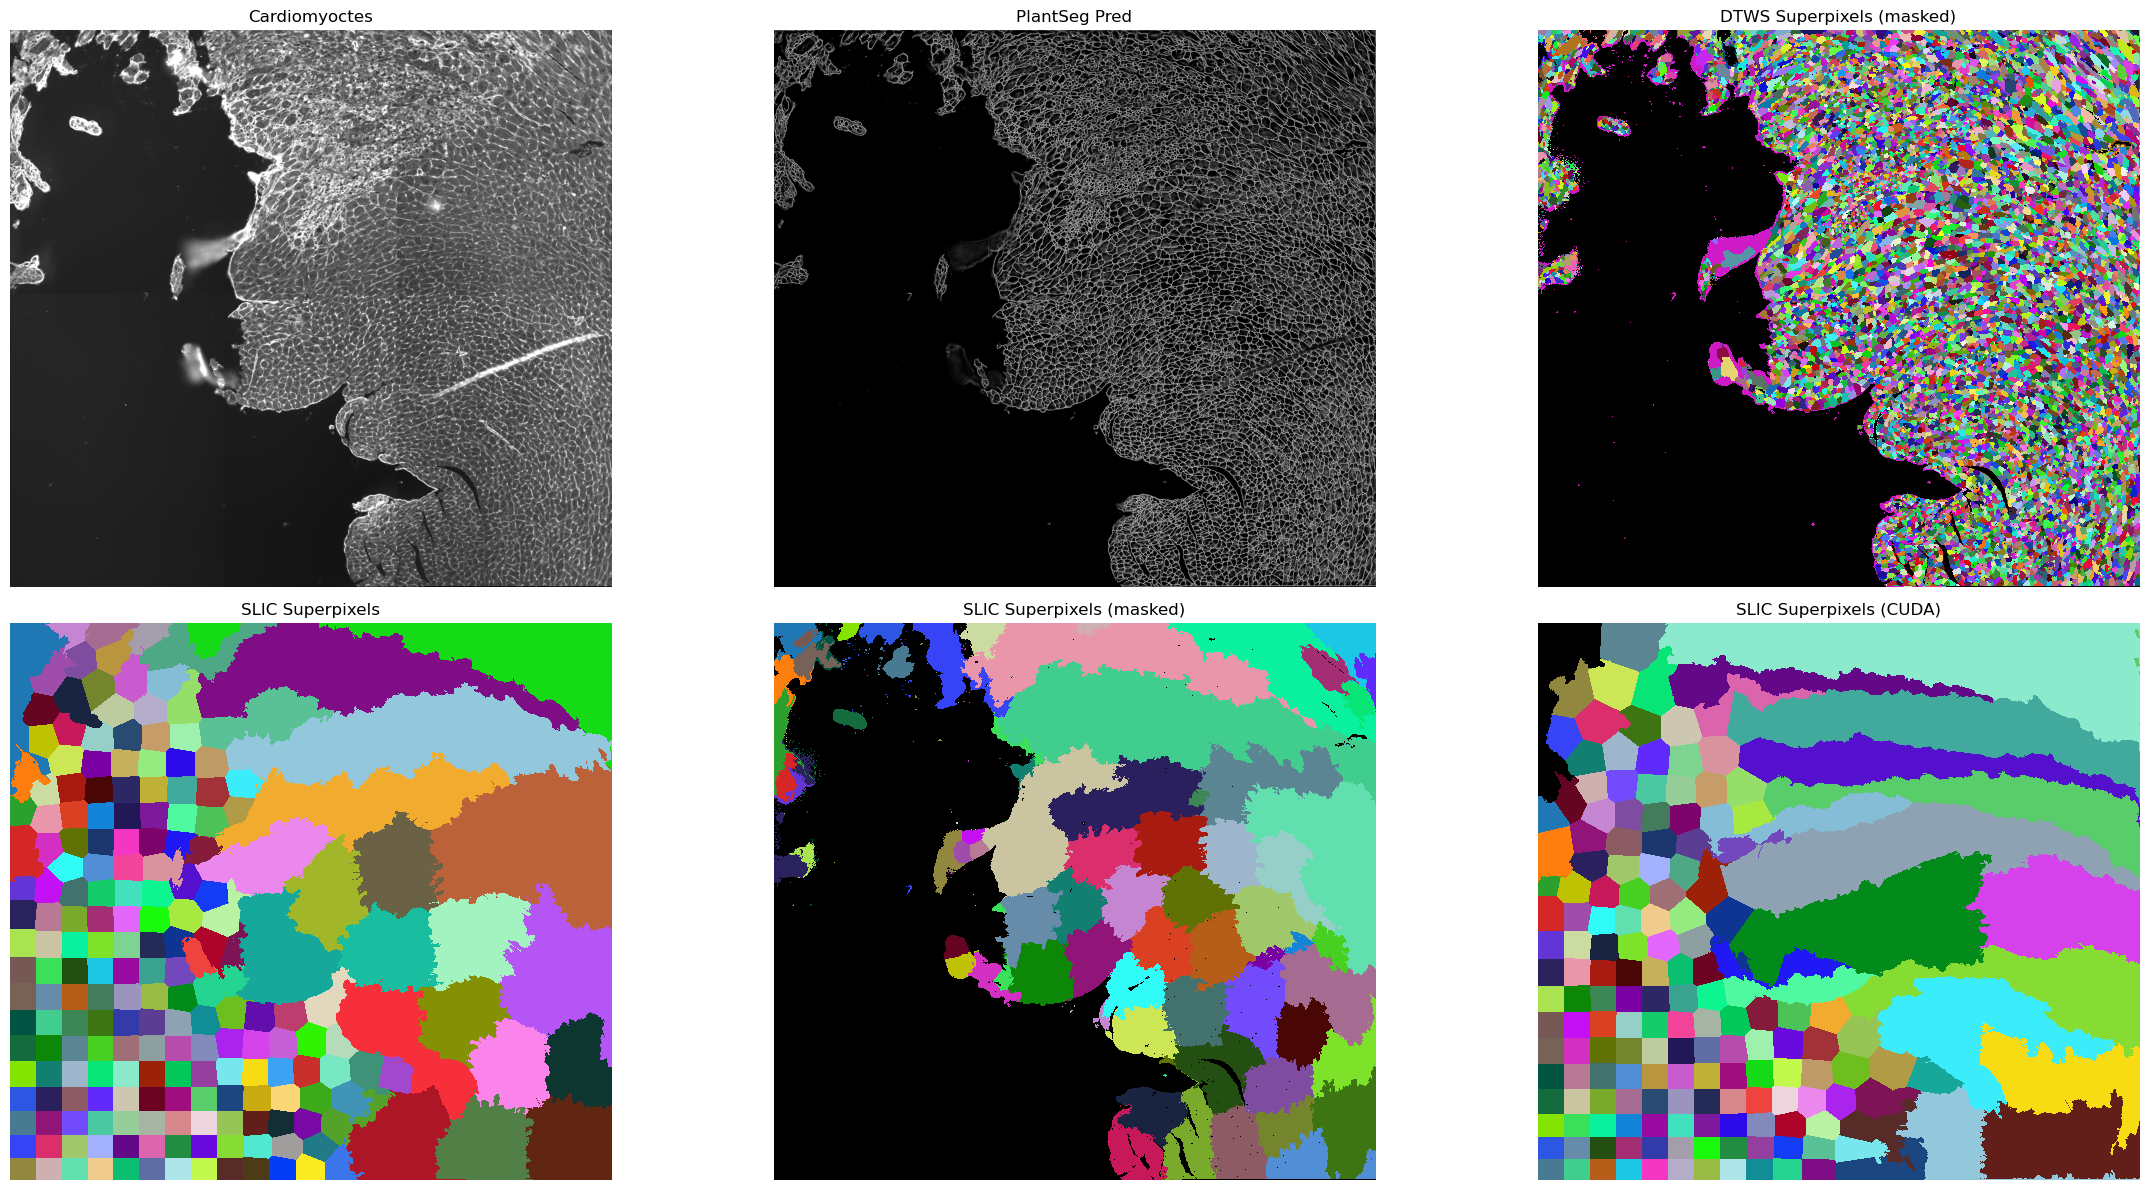

In [25]:
fig, axs = plt.subplots(2,3,figsize=(24,12))
axs=axs.ravel()
axs[0].imshow(img[:,:,0].T,cmap="gray")
axs[0].set_axis_off()
axs[0].set_title("Cardiomyoctes")

axs[1].imshow(pred[0,:,:].T,cmap="gray")
axs[1].set_axis_off()
axs[1].set_title("PlantSeg Pred")

cle.imshow(dt_ws_masked, plot=axs[2],labels=True)
axs[2].set_axis_off()
axs[2].set_title("DTWS Superpixels (masked)")

cle.imshow(slic_ski.T, plot=axs[3],labels=True)
axs[3].set_axis_off()
axs[3].set_title("SLIC Superpixels")
cle.imshow(slic_ski_masked.T, plot=axs[4],labels=True)
axs[4].set_axis_off()
axs[4].set_title("SLIC Superpixels (masked)")
cle.imshow(slic_cuda.T, plot=axs[5],labels=True)
axs[5].set_axis_off()
axs[5].set_title("SLIC Superpixels (CUDA)")
plt.tight_layout()

### GASP

In [26]:
superpixels ={
    "No Superpixels": None,
    "DTWS": dt_ws,
    "DTWS (masked)": dt_ws_masked,
    "SLIC": slic_ski.T,
    "SLIC (masked)": slic_ski_masked.T,
    "SLIC (CUDA)": slic_cuda.T
}

In [57]:
pbar = tqdm(total=len(superpixels))

BETA=0.1
POST_MIN_SIZE=1000

gasp_avg = []
gasp_mutexws = []

for i, (name, sp) in enumerate(superpixels.items()):
    pbar.update(1)
    label_avg = gasp(
        # boundary_pmaps=pred[0,:,:].T,
        boundary_pmaps=pred_masked.T,
        superpixels=sp,
        gasp_linkage_criteria="average",
        beta=BETA,
        post_minsize=POST_MIN_SIZE,
        n_threads=multiprocessing.cpu_count()
        )
    gasp_avg.append(label_avg)

    label_mutexws = gasp(
        # boundary_pmaps=pred[0,:,:].T,
        boundary_pmaps=pred_masked.T,
        superpixels=sp,
        gasp_linkage_criteria="mutex_watershed",
        beta=BETA,
        post_minsize=POST_MIN_SIZE,
        n_threads=multiprocessing.cpu_count()
        )
    gasp_mutexws.append(label_mutexws)

100%|██████████| 6/6 [01:10<00:00,  9.33s/it]

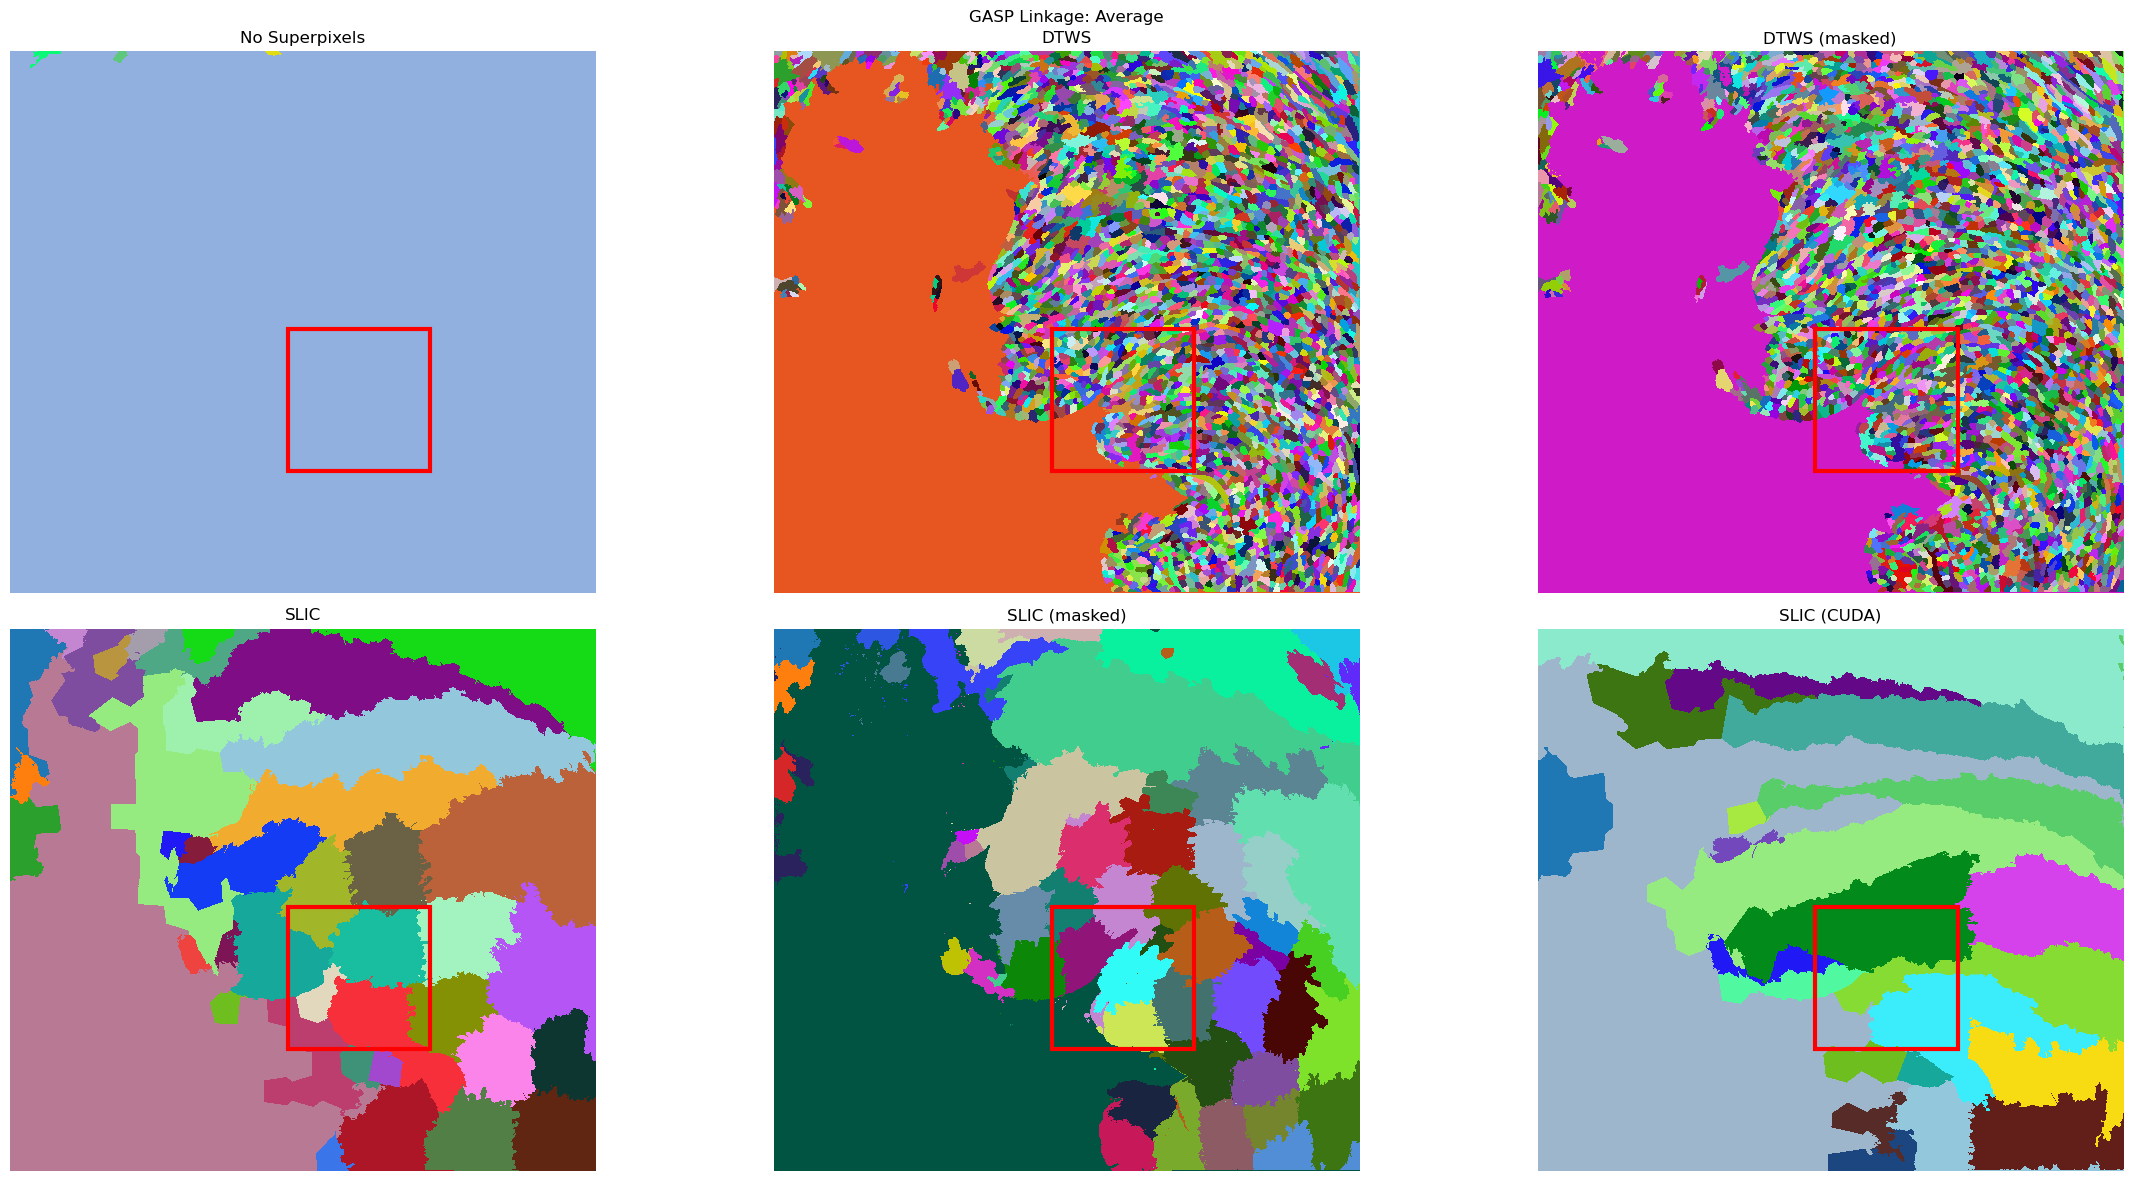

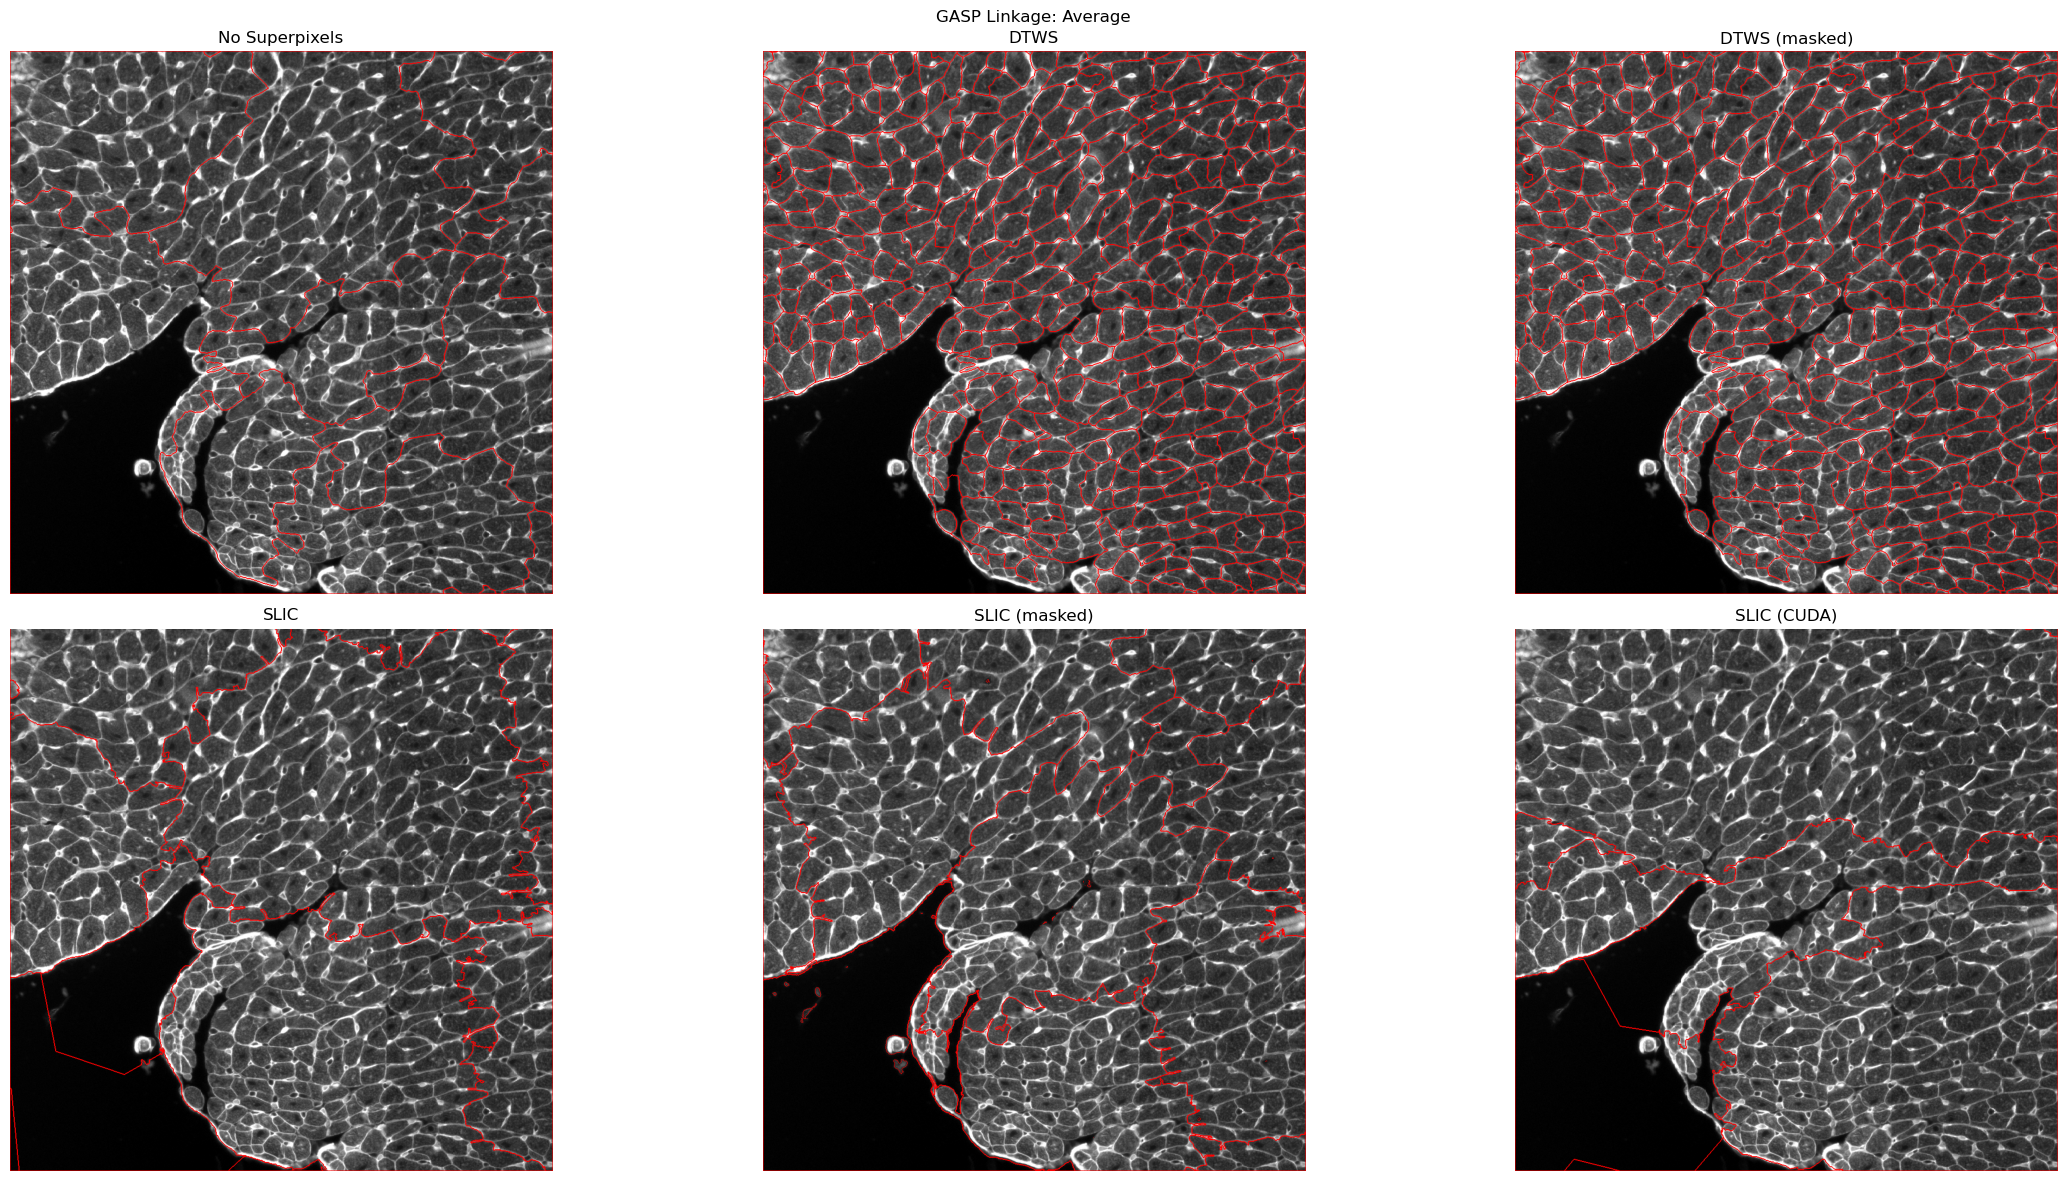

In [58]:
fig, axs = plt.subplots(2,3,figsize=(24,12))
axs=axs.ravel()

for i, (name, sp) in enumerate(superpixels.items()):
    cle.imshow(gasp_avg[i], plot=axs[i],labels=True)
    axs[i].set_axis_off()
    axs[i].set_title(name)
    rect = patches.Rectangle((2000,2000), 1024, 1024, linewidth=3, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    axs[i].add_patch(rect)
    # break
plt.suptitle("GASP Linkage: Average")
plt.tight_layout()

fig, axs= plt.subplots(2,3,figsize=(24,12))
axs=axs.ravel()

for i, (name, sp) in enumerate(superpixels.items()):
    outlines = utils.masks_to_outlines(gasp_avg[i][0,2000:2000+1024,2000:2000+1024],)
    outX, outY = np.nonzero(outlines)
    img0 = image_to_rgb(img[2000:2000+1024,2000:2000+1024,0].T, channels=[0,0])
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red
    axs[i].imshow(imgout)
    axs[i].set_axis_off()
    axs[i].set_title(name)
    # break
plt.suptitle("GASP Linkage: Average")
plt.tight_layout()

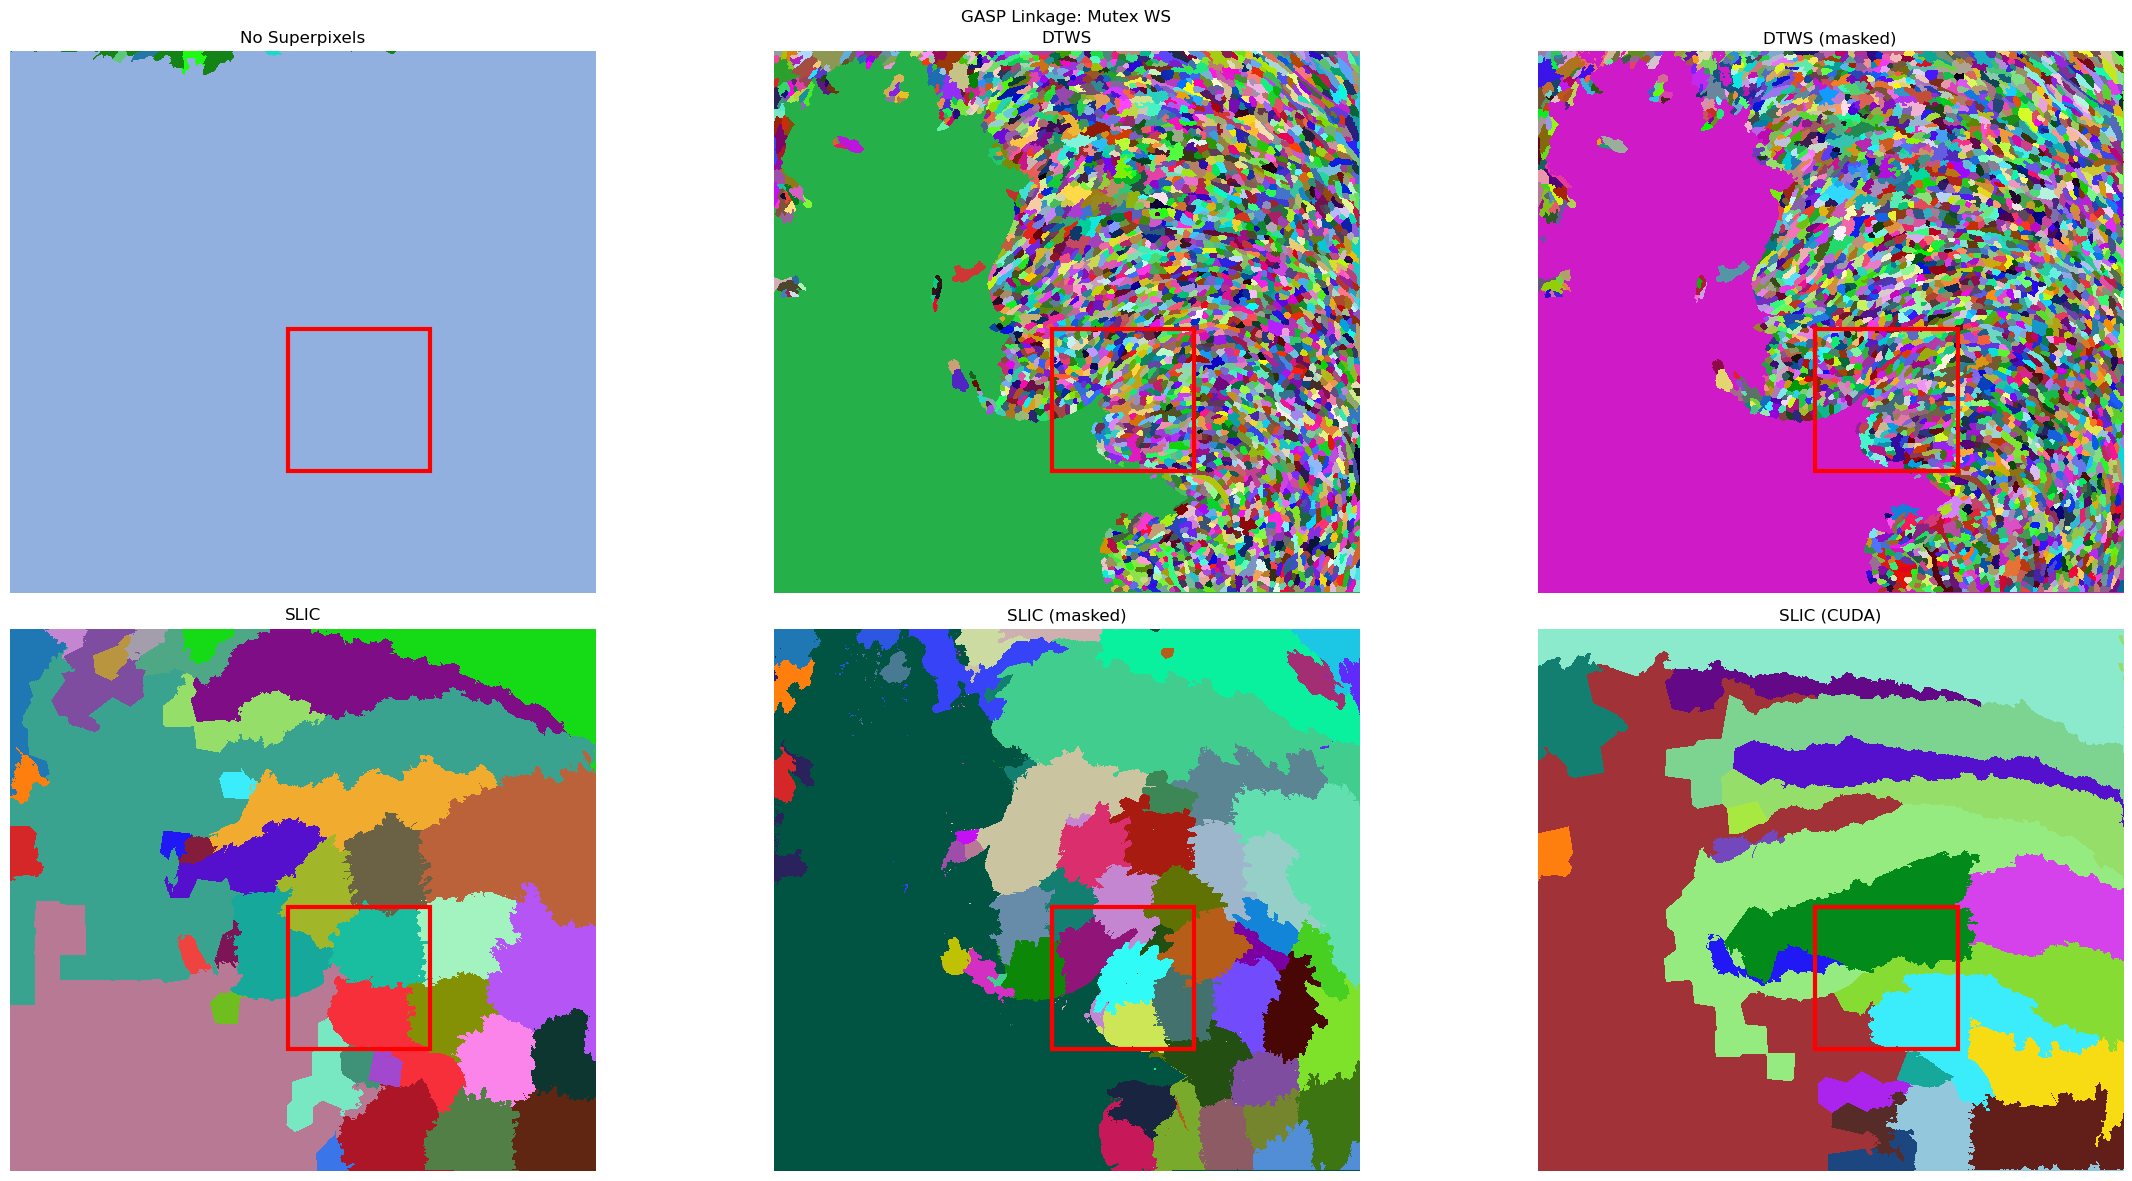

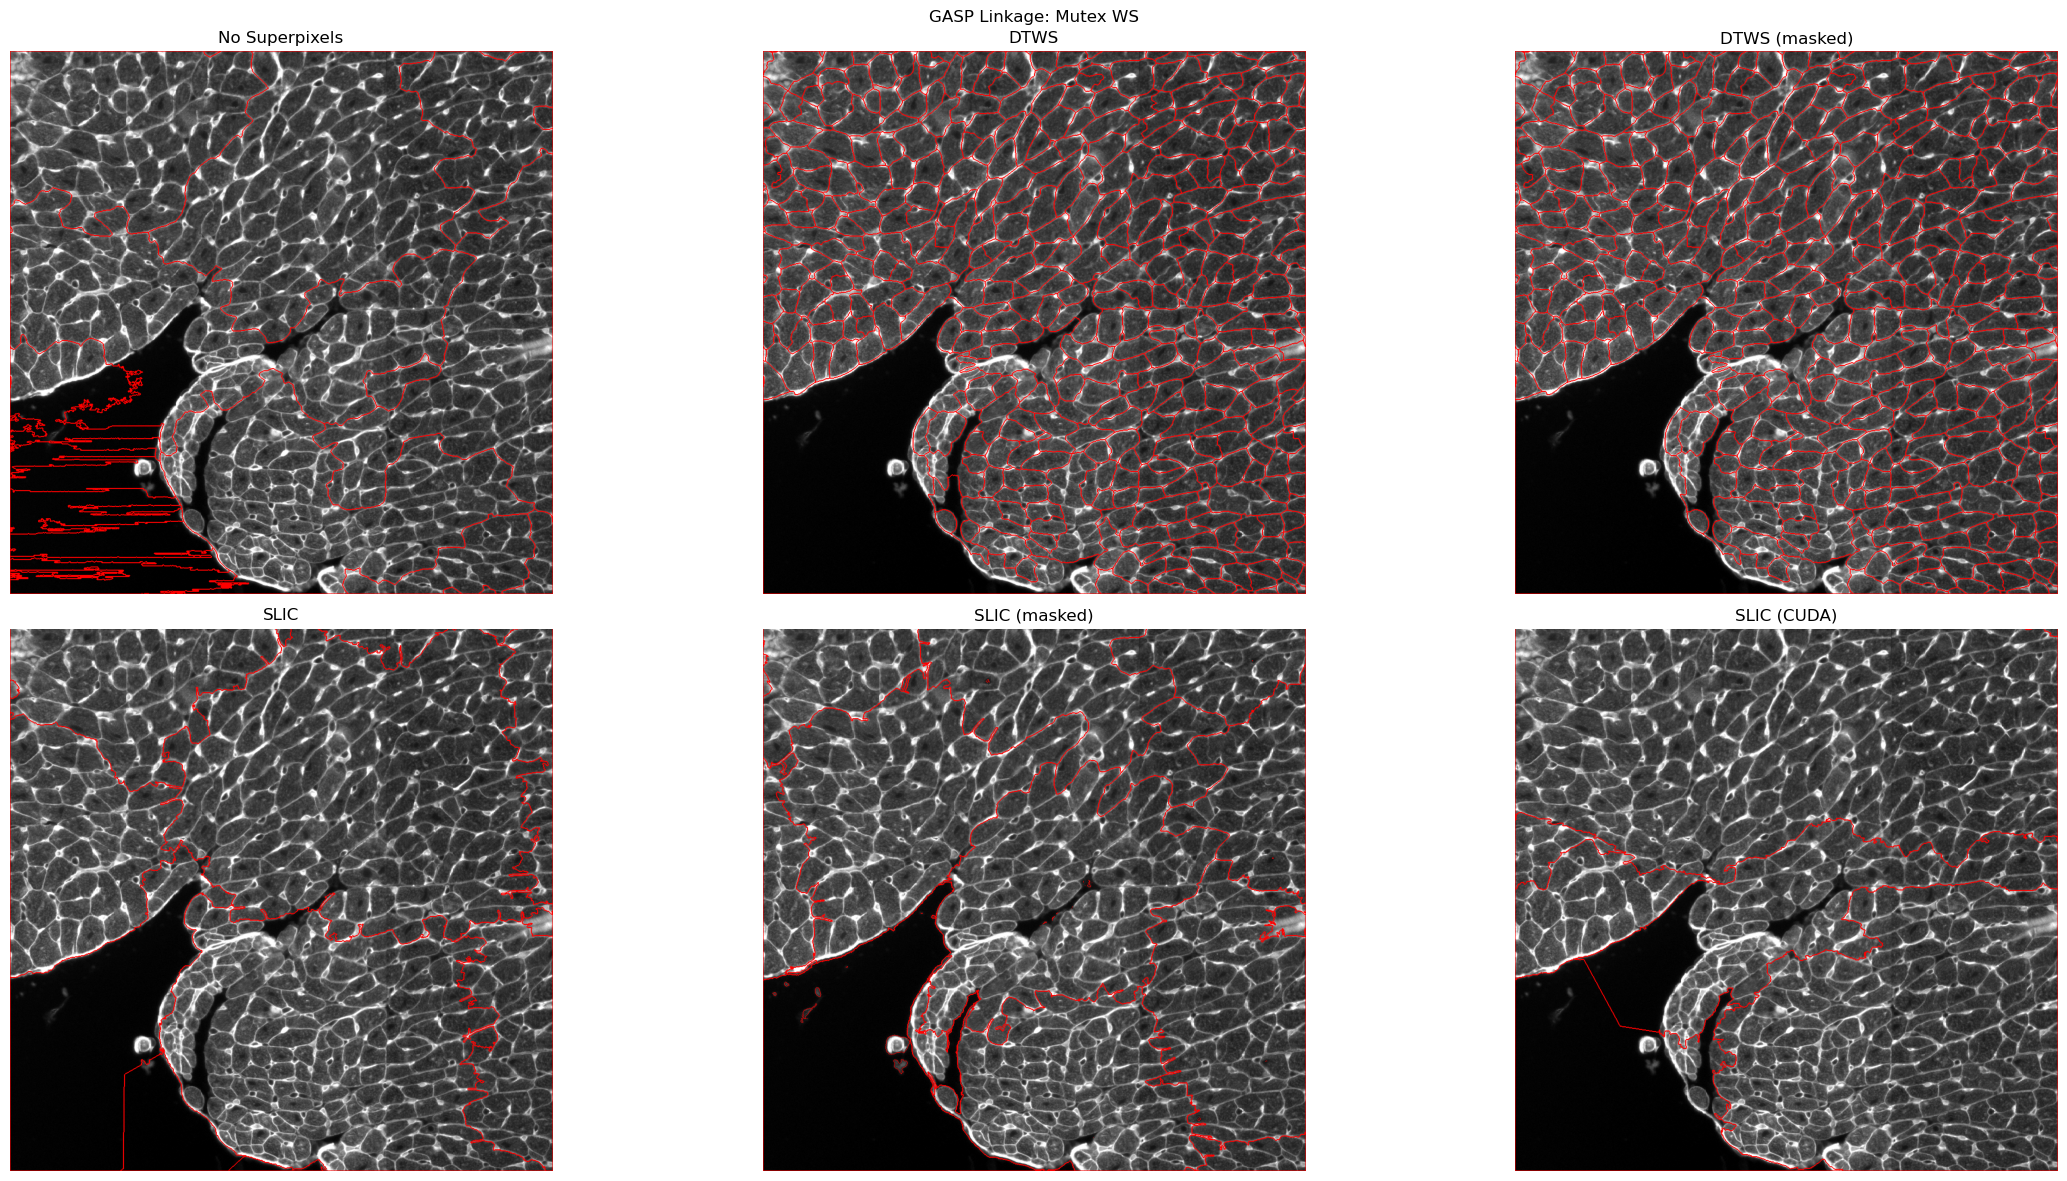

In [59]:
fig, axs = plt.subplots(2,3,figsize=(24,12))
axs=axs.ravel()

for i, (name, sp) in enumerate(superpixels.items()):
    cle.imshow(gasp_mutexws[i], plot=axs[i],labels=True)
    axs[i].set_axis_off()
    axs[i].set_title(name)
    rect = patches.Rectangle((2000,2000), 1024, 1024, linewidth=3, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    axs[i].add_patch(rect)
    # break
plt.suptitle("GASP Linkage: Mutex WS")
plt.tight_layout()

fig, axs= plt.subplots(2,3,figsize=(24,12))
axs=axs.ravel()

for i, (name, sp) in enumerate(superpixels.items()):
    outlines = utils.masks_to_outlines(gasp_mutexws[i][0,2000:2000+1024,2000:2000+1024])
    outX, outY = np.nonzero(outlines)
    img0 = image_to_rgb(img[2000:2000+1024,2000:2000+1024,0].T, channels=[0,0])
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red
    axs[i].imshow(imgout)
    axs[i].set_axis_off()
    axs[i].set_title(name)
    # break
plt.suptitle("GASP Linkage: Mutex WS")
plt.tight_layout()